# 0.0 IMPORTS

In [1]:
import psycopg2
import pandas as pd
import numpy as np
import warnings
import json

import seaborn as sns
import matplotlib.pyplot as plt
import scikitplot as skplt

from IPython.core.display import HTML, display

from sklearn.metrics import precision_score
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn import preprocessing as pp
from sklearn import model_selection as ms
from sklearn import ensemble as en
from sklearn import neighbors as nh
from sklearn.linear_model import LogisticRegression as lr
from sklearn import tree
import pyltr
import cv
import pickle

C:\Users\gusta\AppData\Local\Temp\ipykernel_10756\2018881892.py:11: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display


## 0.1 HELPER FUNCTIONS

In [2]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [15, 8]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()
    
def precision_at_k(data,k):

    data = data.reset_index(drop=True)
    data['ranking'] = data.index + 1

    data['precision_at_k'] = data['response'].cumsum()/data['ranking']

    return data.loc[k,'precision_at_k']

def recall_at_k(data,k):

    data = data.reset_index(drop=True)
    data['ranking'] = data.index + 1

    data['recall_at_k'] = data['response'].cumsum()/data['response'].sum()
    
    return data.loc[k,'recall_at_k']

def gain_lift_curve(yhat, yval, plot = True, size = (6,8)):
    '''
    plots gain and lift curve, respectively
    returns the curves and a table used to plot the curves
    '''

    # create table proba with the propensity score for each class (0 and 1)
    table_proba = pd.DataFrame(yhat)

    # add the 'response' column
    table_proba['target'] = yval.values

    # add the 'correct' column to evaluate wheter the prediction was right or not
    x = lambda x: "yes" if x[0] > x[1] and x['target'] == 0 else "yes" if x[1] > x[0] and x['target'] == 1 else "yes" if x[0] == x[1] else "no" 
    table_proba['correct'] = table_proba.apply(x, axis = 1)

    # order by propensity score for the class 1
    table_proba.sort_values(1, ascending = False, inplace = True)

    # create cumulative propensity score
    ## calculate the quantity of class 1 rows
    qty_class_1 = table_proba.groupby('target').count().loc[1,1]

    ## apply a score for every row which target is 1
    x = lambda x: 1/qty_class_1 if x['target'] == 1 else 0
    table_proba['propensity_score'] = table_proba.apply(x, axis = 1)
    table_proba['cumulative_propensity_score'] = np.cumsum(table_proba['propensity_score'])

    # create % cumulative of the base
    x = lambda x: 1/len(table_proba)
    table_proba['porc_base'] = table_proba.apply(x, axis = 1)
    table_proba['cumulative_porc_base'] = np.cumsum(table_proba['porc_base'])
    table_proba.drop('porc_base', axis = 1, inplace = True)

    # create the lift column
    table_proba['lift'] = table_proba['cumulative_propensity_score'] / table_proba['cumulative_porc_base']

    if plot:
        fig, axes = plt.subplots(2, 1, figsize=size)

        # gap between graphics
        fig.tight_layout(pad =5)

        # gain curve
        sns.lineplot(ax = axes[0], x = table_proba['cumulative_porc_base'], y = table_proba['cumulative_propensity_score'], label="cumulative (model)", linewidth = 2.5);
        sns.lineplot(ax = axes[0], x = table_proba['cumulative_porc_base'], y = table_proba['cumulative_porc_base'], label="baseline", linewidth = 2.5, color = 'black' )
        axes[0].lines[1].set_linestyle("--")
        axes[0].legend()
        axes[0].set_title("cumulative gains curve")
        axes[0].set_xlabel("percentage of sample")
        axes[0].set_ylabel("gain")

        # lift curve
        ## do not consider the beginning of the series, as it varies a lot (the sample is still small)
        table_proba_filtered = table_proba.query('cumulative_porc_base >= 0.1')

        sns.lineplot(ax = axes[1], x = table_proba_filtered['cumulative_porc_base'], y = table_proba_filtered['lift'], label="model", linewidth = 2.5 );
        sns.lineplot(ax = axes[1], x = table_proba_filtered['cumulative_porc_base'], y = np.ones(len(table_proba_filtered)), label="baseline", linewidth = 2.5, color = 'black' )
        axes[1].lines[1].set_linestyle("--")
        axes[1].legend()
        axes[1].set_title("lift curve")
        axes[1].set_xlabel("percentage of sample")

        plt.show();
        
    return (table_proba)

def precision_recall_at_k(table, k = 2000):
    ''' 
    receives the table that was generated in gain_lift_curve function and returns: 
    - a tuple containg the precision at k and recall at k, respectively
    - a new table with precision_at_k and recall_at_k metrics 
    '''
    table.reset_index(drop=True, inplace = True)
    table['ranking'] = table.index + 1 # as the index starts in 0 it is necessary to +1
    table['precision_at_k'] = table['target'].cumsum() / table['ranking']
    table['recall_at_k'] = table['target'].cumsum() / table['target'].sum()
    return ((table.loc[k-1, 'precision_at_k'], table.loc[k-1, 'recall_at_k']),table)

In [3]:
jupyter_settings();
warnings.filterwarnings("ignore");

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


## 0.2 FETCHING DATA 

In [4]:
with open('.credentials.json') as json_file:
    cred = json.load(json_file)

conn = psycopg2.connect(dbname=cred['dbname'], user=cred['user'], password=cred['password'],host=cred['host'],port=cred['port'])

cursor = conn.cursor()
cursor.execute('select schema_name from information_schema.schemata')
schemas = cursor.fetchall()
print(schemas)

cursor.close()

[('pg_catalog',), ('information_schema',), ('public',), ('pa004',)]


In [5]:
query_tables = "select table_name from information_schema.tables where table_schema = 'pa004' "

cursor = conn.cursor()
cursor.execute(query_tables)
tables = cursor.fetchall()
print(tables)

users = pd.read_sql_query('select * from pa004.users',conn)
vehicle = pd.read_sql_query('select * from pa004.vehicle',conn)
insurance = pd.read_sql_query('select * from pa004.insurance',conn)

cursor.close()
conn.close()

[('users',), ('vehicle',), ('insurance',)]


In [6]:
df = pd.merge(users, vehicle, on='id')
df = pd.merge(df,insurance,on='id')
df.head()

,id,gender,age,region_code,policy_sales_channel,driving_license,vehicle_age,vehicle_damage,previously_insured,annual_premium,vintage,response
0,1,Male,44,28.0,26.0,1,> 2 Years,Yes,0,40454.0,217,1
1,2,Male,76,3.0,26.0,1,1-2 Year,No,0,33536.0,183,0
2,3,Male,47,28.0,26.0,1,> 2 Years,Yes,0,38294.0,27,1
3,4,Male,21,11.0,152.0,1,< 1 Year,No,1,28619.0,203,0
4,5,Female,29,41.0,152.0,1,< 1 Year,No,1,27496.0,39,0


# 1.0 DATA DESCRIPTION

In [7]:
df1 = df.copy()

## 1.1 DATA DIMENSIONS

In [190]:
print('Rows: {}'.format(df1.shape[0]))
print('Columns: {}'.format(df1.shape[1]))

Rows: 381109
Columns: 12


## 1.2 DATA TYPES

In [94]:
df1.dtypes

id                        int64
gender                   object
age                       int64
region_code             float64
policy_sales_channel    float64
driving_license           int64
vehicle_age              object
vehicle_damage           object
previously_insured        int64
annual_premium          float64
vintage                   int64
response                  int64
dtype: object

## 1.3 CHECKING NA DATA

In [95]:
df1.isna().sum()

id                      0
gender                  0
age                     0
region_code             0
policy_sales_channel    0
driving_license         0
vehicle_age             0
vehicle_damage          0
previously_insured      0
annual_premium          0
vintage                 0
response                0
dtype: int64

## 1.4 CHANGING TYPES

In [112]:
df1['region_code'] = df1['region_code'].astype('int64')
df1['policy_sales_channel'] = df1['policy_sales_channel'].astype('int64')

## 1.5 STATISTIC DESCRIPTION

In [202]:
num_attributes = df1.select_dtypes(include=['int64','float64'])
cat_attributes = df1.select_dtypes(exclude=['int64','float64','datetime64[ns]'])

### 1.5.1 NUMERICAL ATTRIBUTES

In [98]:
# Central tendency: mean, median
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

#Dispersion: std, min, max, range, skew, kurtosis
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(min)).T
d3 = pd.DataFrame(num_attributes.apply(max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max()-x.min())).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

#Concatenate
m = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
m.columns=['attributes','min','max','range','mean','median','std','skew','kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,id,1.0,381109.0,381108.0,190555.000000,190555.0,110016.691870,9.443274e-16,-1.200000
1,age,20.0,85.0,65.0,38.822584,36.0,15.511591,6.725390e-01,-0.565655
2,region_code,0.0,52.0,52.0,26.388807,28.0,13.229871,-1.152664e-01,-0.867857
3,policy_sales_channel,1.0,163.0,162.0,112.034295,133.0,54.203924,-9.000081e-01,-0.970810
4,driving_license,0.0,1.0,1.0,0.997869,1.0,0.046109,-2.159518e+01,464.354302
5,previously_insured,0.0,1.0,1.0,0.458210,0.0,0.498251,1.677471e-01,-1.971871
6,annual_premium,2630.0,540165.0,537535.0,30564.389581,31669.0,17213.132474,1.766087e+00,34.004569
7,vintage,10.0,299.0,289.0,154.347397,154.0,83.671194,3.029517e-03,-1.200688
8,response,0.0,1.0,1.0,0.122563,0.0,0.327935,2.301906e+00,3.298788


### 1.5.2 CATEGORICAL ATTRIBUTES

In [203]:
cat_attributes.apply(lambda x: x.unique())

gender                             [Male, Female]
vehicle_age       [> 2 Years, 1-2 Year, < 1 Year]
vehicle_damage                          [Yes, No]
dtype: object

# 2.0 FEATURE ENGINEERING

In [8]:
df2 = df1.copy()

## 2.1 HYPOTHESIS LIST

1. Older people will be more interested.
2. People with a drivers license will be more interested.
3. People previously ensured will be more interested.
4. People with lower annual premium are the most interested.
5. People with higher vehicle age will be more interested.
6. People that had their vehicle damaged will be more interested.

## 2.2 FEATURE ENGINEERING

In [205]:
ins_cat = df2[['driving_license','previously_insured','response']]
cat_attributes = cat_attributes.join(ins_cat)
num_attributes = num_attributes.drop(ins_cat,axis=1)

# vehicle age
dict_vehicle_age = {'> 2 Years':'over_2_years', '1-2 Year':'between_1_2_years', '< 1 Year':'under_1_year'}
df2['vehicle_age'] = df2['vehicle_age'].map(dict_vehicle_age)
cat_attributes['vehicle_age'] = cat_attributes['vehicle_age'].map(dict_vehicle_age)

# vehicle damage
dict_vehicle_damage = {'Yes': 1, 'No': 0}
df2['vehicle_damage'] = df2['vehicle_damage'].map(dict_vehicle_damage)
cat_attributes['vehicle_damage'] = cat_attributes['vehicle_damage'].map(dict_vehicle_damage)

df2.head()

,id,gender,age,region_code,policy_sales_channel,driving_license,vehicle_age,vehicle_damage,previously_insured,annual_premium,vintage,response
0,1,Male,44,28.0,26.0,1,over_2_years,1,0,40454.0,217,1
1,2,Male,76,3.0,26.0,1,between_1_2_years,0,0,33536.0,183,0
2,3,Male,47,28.0,26.0,1,over_2_years,1,0,38294.0,27,1
3,4,Male,21,11.0,152.0,1,under_1_year,0,1,28619.0,203,0
4,5,Female,29,41.0,152.0,1,under_1_year,0,1,27496.0,39,0


# 3.0 EXPLORATORY DATA ANALYSIS

In [9]:
df3 = df2.copy()

## 3.1 UNIVARIATE ANALYSIS

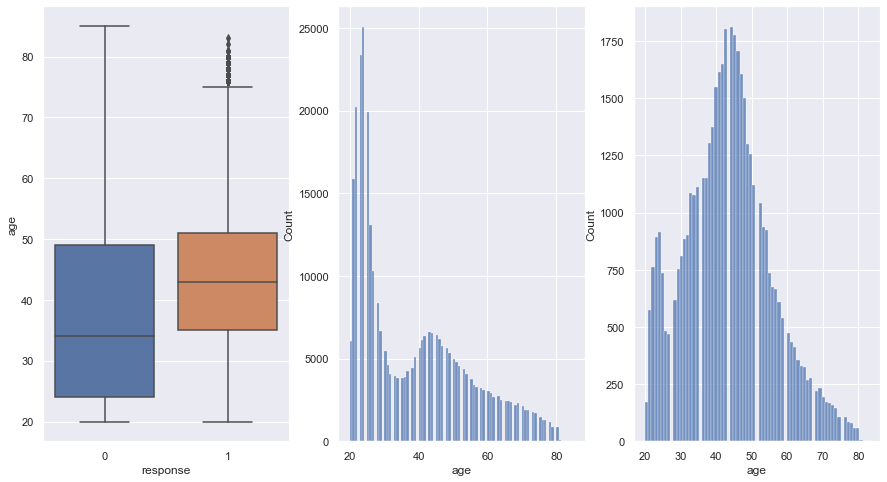

In [19]:
#age
plt.subplot(1,3,1)
sns.boxplot(x='response',y='age',data=df3);

aux_0 = df3.loc[df3['response']==0,'age']
plt.subplot(1,3,2)
sns.histplot(aux_0);

aux_1 = df3.loc[df3['response']==1,'age']
plt.subplot(1,3,3)
sns.histplot(aux_1);

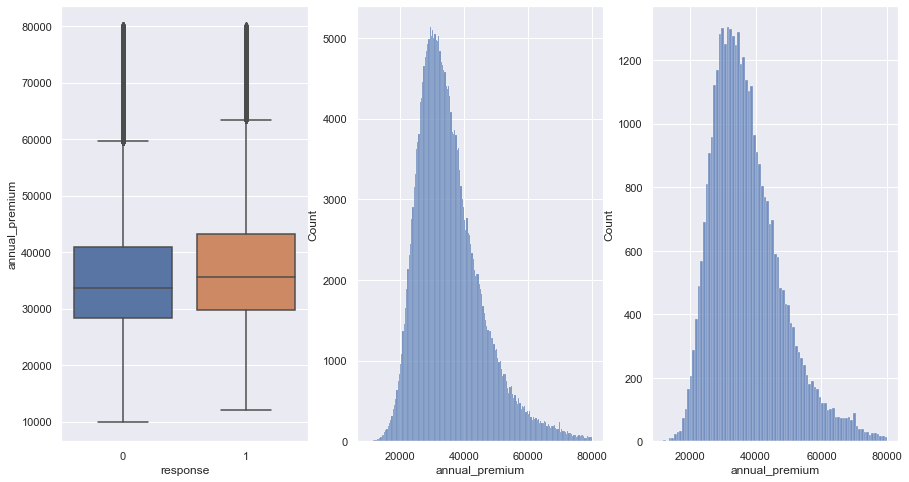

In [20]:
#annual_premium
plt.subplot(1,3,1)
aux = df3[(df3['annual_premium']<80000) & (df3['annual_premium']>10000)]
sns.boxplot(x='response',y='annual_premium',data=aux);

aux_0 = aux.loc[df3['response']==0,'annual_premium']
plt.subplot(1,3,2)
sns.histplot(aux_0);

aux_1 = aux.loc[df3['response']==1,'annual_premium']
plt.subplot(1,3,3)
sns.histplot(aux_1);

In [21]:
#driving_license
aux = df3[['driving_license','response']].groupby('response').sum().reset_index()
aux.head()
aux['driving_license_perc'] = aux['driving_license']/aux['driving_license'].sum()
aux

,response,driving_license,driving_license_perc
0,0,333628,0.877283
1,1,46669,0.122717


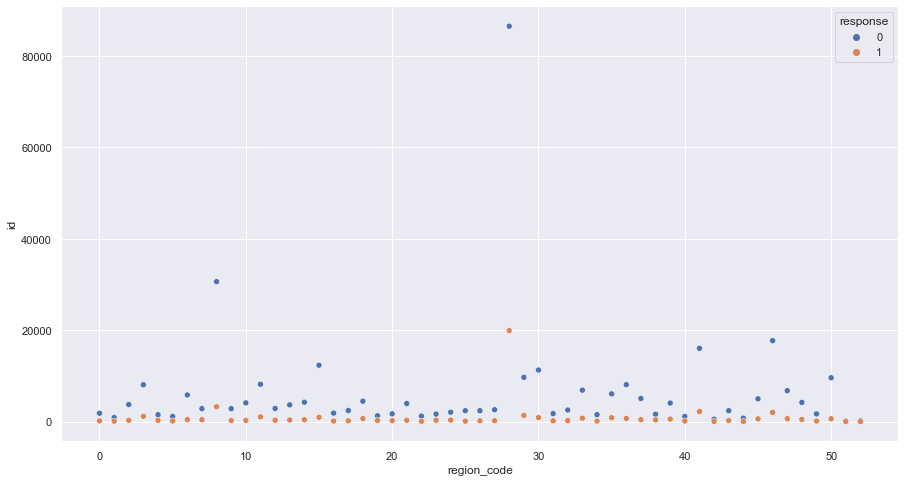

In [22]:
#region_code
aux = df3[['id','region_code','response']].groupby(['region_code','response']).count().reset_index()
sns.scatterplot(x='region_code',y='id',hue='response',data=aux);

In [23]:
#previously_insured
pd.crosstab(df3['previously_insured'],df3['response']).apply(lambda x: x/x.sum(),axis=1)

response,0,1
previously_insured,,
0,0.774546,0.225454
1,0.999095,0.000905


In [24]:
#vehicle_age
df3[['vehicle_age','response']].value_counts(normalize=True).reset_index().sort_values('vehicle_age')

,vehicle_age,response,0
0,between_1_2_years,0,0.434285
2,between_1_2_years,1,0.091328
3,over_2_years,0,0.029663
5,over_2_years,1,0.012338
1,under_1_year,0,0.413488
4,under_1_year,1,0.018897


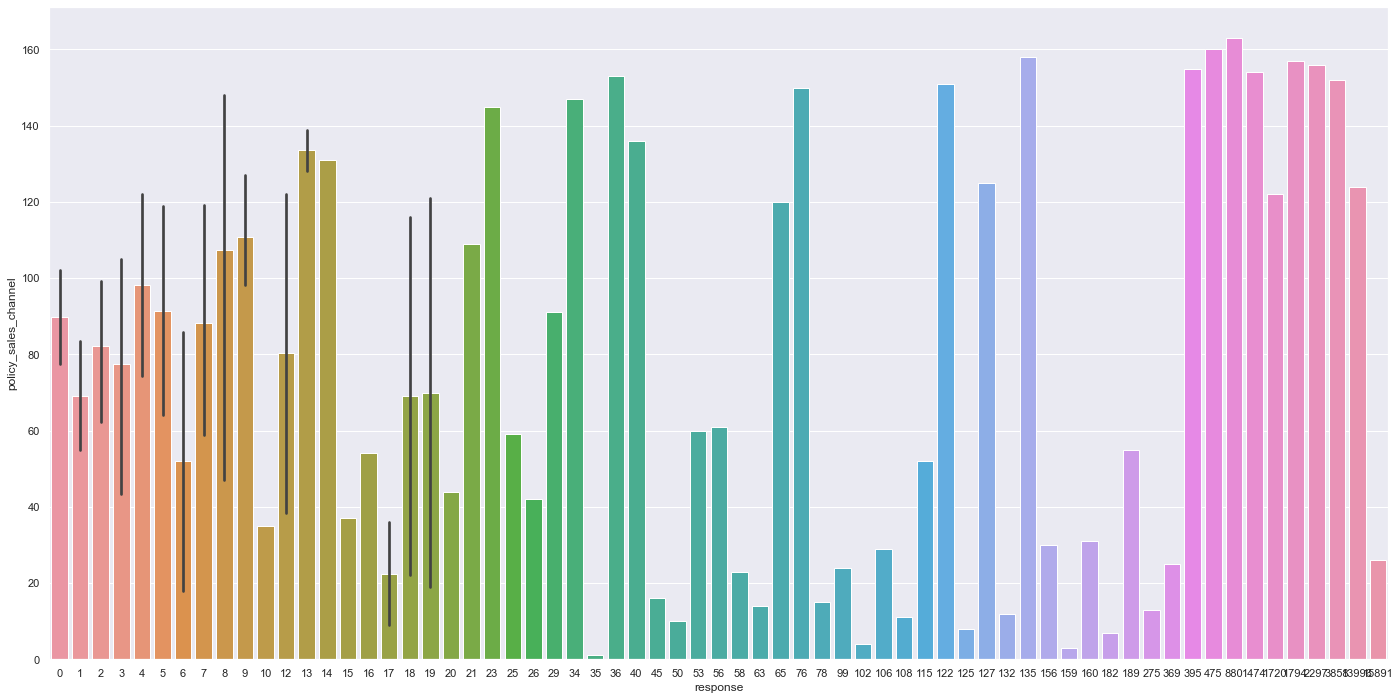

In [25]:
#policy_sales_channel
plt.figure(figsize=(24,12))
aux = df3[['policy_sales_channel','response']].groupby('policy_sales_channel').sum().reset_index()
sns.barplot(x='response',y='policy_sales_channel',data=aux);

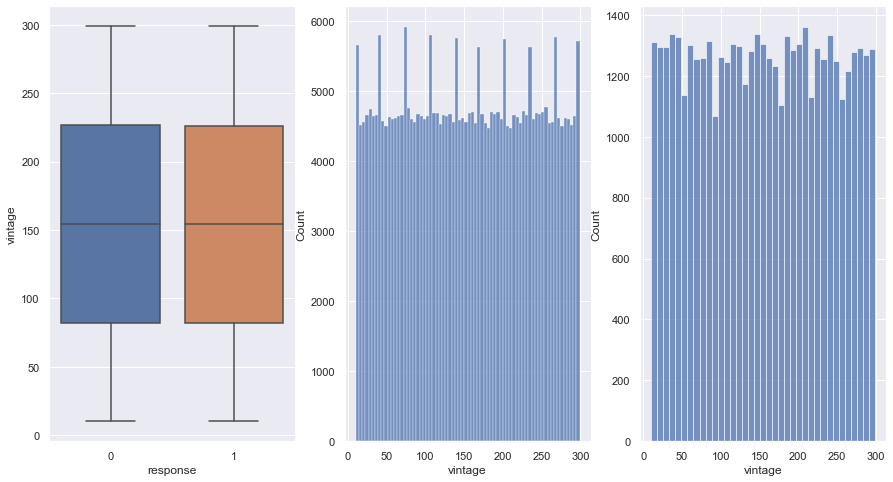

In [26]:
#vintage
plt.subplot(1,3,1)
sns.boxplot(x='response',y='vintage',data=df3);

aux_0 = df3.loc[df3['response']==0,'vintage']
plt.subplot(1,3,2)
sns.histplot(aux_0);

aux_1 = df3.loc[df3['response']==1,'vintage']
plt.subplot(1,3,3)
sns.histplot(aux_1);

## 3.2 BIVARIATE ANALYSIS

In [27]:
aux32 = df3[df3['response']==1]
aux32.columns

Index(['id', 'gender', 'age', 'region_code', 'policy_sales_channel',
       'driving_license', 'vehicle_age', 'vehicle_damage',
       'previously_insured', 'annual_premium', 'vintage', 'response'],
      dtype='object')

### 1. Older people will be more interested.
**FALSE.** The people that are more interested are around the median.

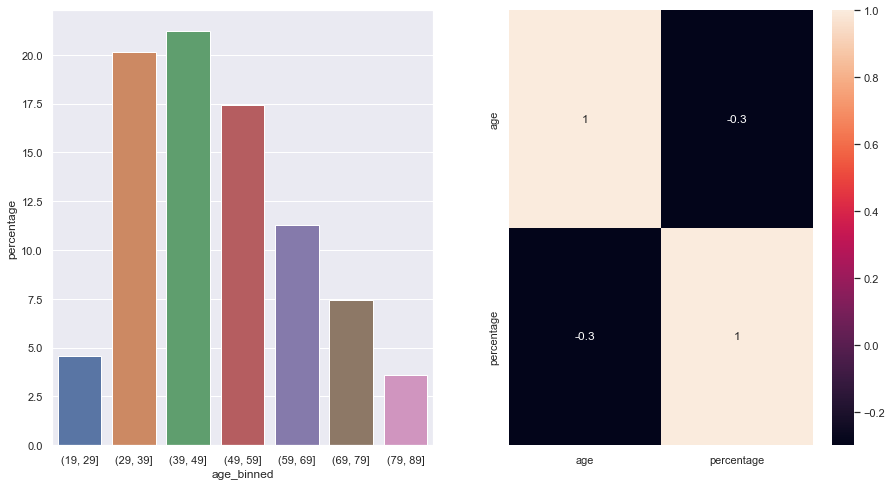

In [28]:
h1 = df3[['age','response']].groupby('age').count().reset_index()
h11 = aux32[['age','response']].groupby('age').count().reset_index()
h111 = pd.merge(h1,h11,on='age',how='left')
h111 = h111.fillna(0)

h111['percentage'] = (h111['response_y']/h111['response_x']) *100

bins = list(np.arange(19,90,10))

h111['age_binned'] = pd.cut(h111['age'],bins=bins)
h12 = h111[['age_binned','percentage']].groupby('age_binned').mean().reset_index()


plt.subplot(1,2,1)
sns.barplot(x='age_binned',y='percentage',data=h12);
#plt.xticks(rotation=90);

plt.subplot(1,2,2)
h111.drop(['response_x','response_y'],inplace=True,axis=1)
sns.heatmap(h111.corr(method='pearson'),annot=True);


### 2. People with a drivers license will be more interested.
**TRUE.** People with a drivers license are more interested.

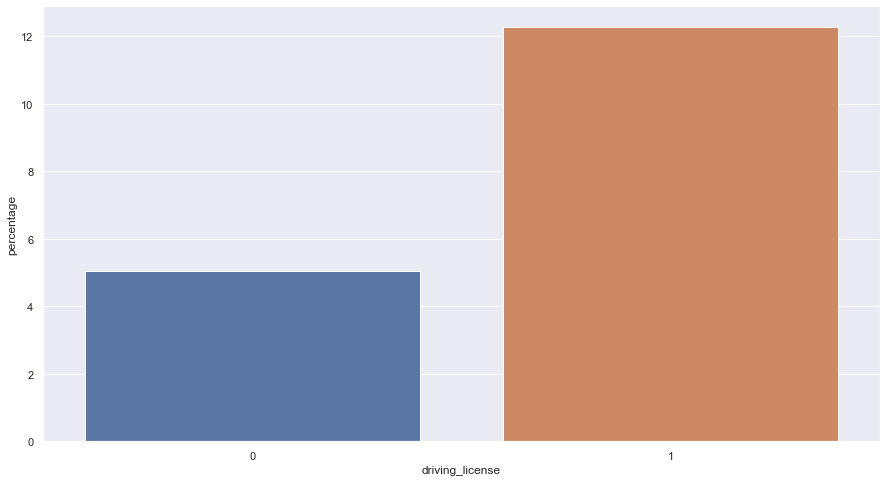

In [29]:
h2 = df3[['driving_license','response']].groupby('driving_license').count().reset_index()
h21 = aux32[['driving_license','response']].groupby('driving_license').count().reset_index()
h21['percentage'] = (h21['response']/h2['response']) *100

sns.barplot(x='driving_license',y='percentage',data=h21);

### 3. People previously ensured will be more interested.
**FALSE.** People previously ensured are less interested.

In [30]:
h3 = df3[['previously_insured','response']].groupby('previously_insured').count().reset_index()
h31 = aux32[['previously_insured','response']].groupby('previously_insured').count().reset_index()
h31['percentage'] = (h31['response']/h3['response']) *100
h31.drop('response',axis=1, inplace=True)

print(h31)

   previously_insured  percentage
0                   0   22.545416
1                   1    0.090478


### 4. People with lower annual premium are the most interested.
**TRUE.** However, that only applies to the <10k range.

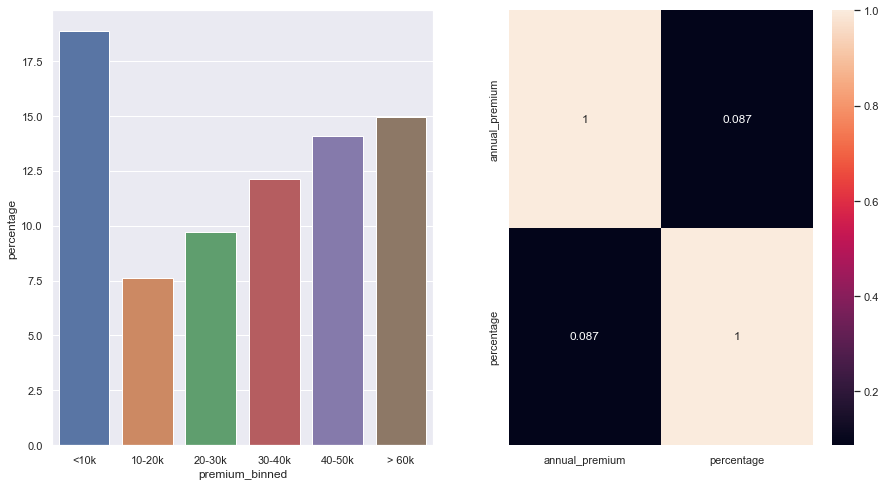

In [31]:
h4 = df3[['annual_premium','response']].groupby('annual_premium').count().reset_index()
h41 = aux32[['annual_premium','response']].groupby('annual_premium').count().reset_index()
h411 = pd.merge(h4,h41,on='annual_premium',how='left')
h411 = h411.fillna(0)
h411['percentage'] = (h411['response_y']/h411['response_x']) *100

bins = [0, 10000, 20000, 30000, 40000, 50000, 60000]
labels = ['<10k','10-20k','20-30k', '30-40k', '40-50k', '> 60k']
h411['premium_binned'] = pd.cut(h411['annual_premium'],bins=bins, labels=labels)
h42 = h411[['premium_binned','percentage']].groupby('premium_binned').mean().reset_index()

plt.subplot(1,2,1)
sns.barplot(x='premium_binned',y='percentage',data=h42);

plt.subplot(1,2,2)
h411.drop(['response_x','response_y'],inplace=True,axis=1)
sns.heatmap(h411.corr(method='pearson'),annot=True);

### 5. People with higher vehicle age will be more interested.
**TRUE.** People with higher vehicle age are percentually more interested.

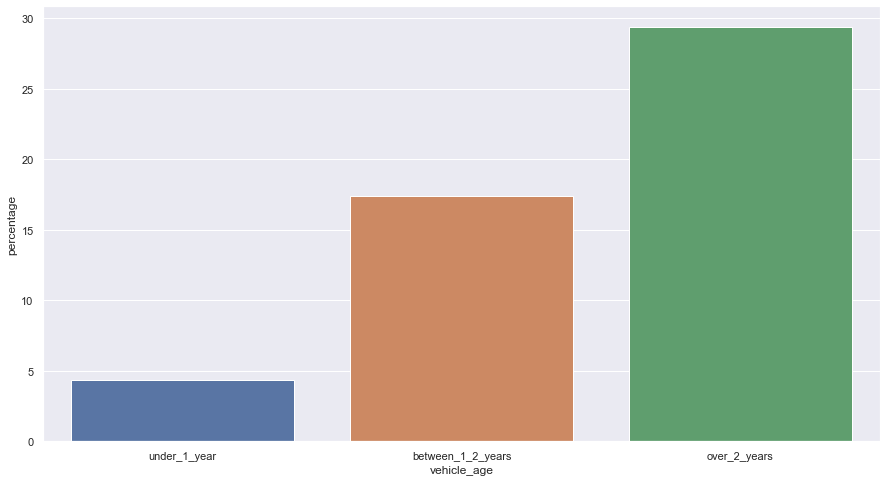

In [32]:
h5 = df3[['vehicle_age','response']].groupby('vehicle_age').count().reset_index()
h51 = aux32[['vehicle_age','response']].groupby('vehicle_age').count().reset_index()
h511 = pd.merge(h5,h51,on='vehicle_age',how='left')
h511 = h511.fillna(0)
h511['percentage'] = (h511['response_y']/h511['response_x']) *100

order = ['under_1_year','between_1_2_years','over_2_years']
sns.barplot(x='vehicle_age',y='percentage',data=h511, order=order);

### 6. People that had their vehicle damaged will be more interested.
**TRUE**. People with higher vehicle age are percentually more interested.

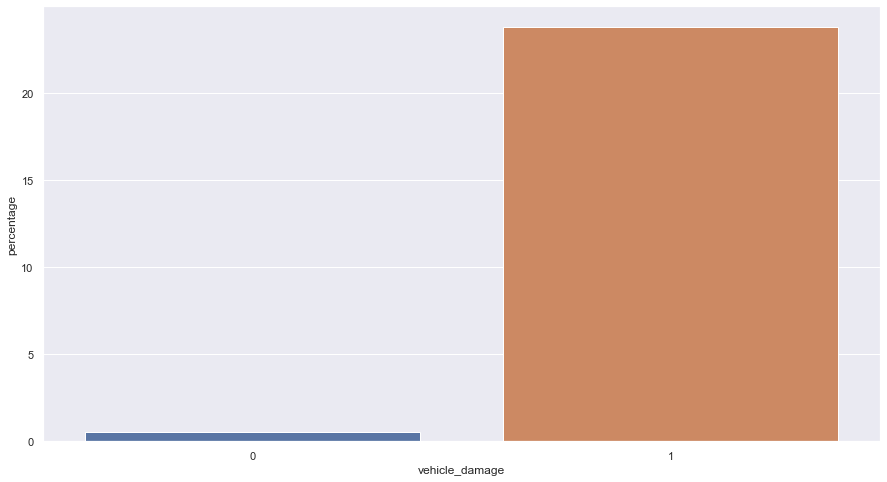

In [33]:
h6 = df3[['vehicle_damage','response']].groupby('vehicle_damage').count().reset_index()
h61 = aux32[['vehicle_damage','response']].groupby('vehicle_damage').count().reset_index()
h611 = pd.merge(h6,h61,on='vehicle_damage',how='left')
h611 = h611.fillna(0)
h611['percentage'] = (h611['response_y']/h611['response_x']) *100


sns.barplot(x='vehicle_damage',y='percentage',data=h611);

# 4.0 DATA PREPARATION 

In [10]:
df4 = df3.copy()

## 4.1 SPLITTING

In [11]:
X = df4.drop('response',axis=1)
y = df4['response'].copy()

x_train, x_val, y_train, y_val = ms.train_test_split(X, y, stratify=y, test_size=0.20)

df4 = pd.concat([x_train, y_train], axis=1)

## 4.1 TRAIN STANDARDIZATION

In [209]:
#annual_premium
ss = pp.StandardScaler()
df4['annual_premium'] = ss.fit_transform(df4[['annual_premium']].values)
pickle.dump(ss, open('/Users/gusta/Documents/repos/health-cross-sell/scalers/annual_premium_scaler.pkl', 'wb'))

## 4.2 TRAIN RESCALING

In [210]:
mms_age = pp.MinMaxScaler()
mms_vintage = pp.MinMaxScaler()
#age
df4['age'] = mms_age.fit_transform(df4[['age']].values)
pickle.dump(mms_age, open('/Users/gusta/Documents/repos/health-cross-sell/scalers/age_scaler.pkl', 'wb'))
#vintage
df4['vintage'] = mms_vintage.fit_transform(df4[['vintage']].values)
pickle.dump(mms_vintage, open('/Users/gusta/Documents/repos/health-cross-sell/scalers/vintage_scaler.pkl', 'wb'))

## 4.3 TRAIN ENCODING 

In [211]:
# gender - Hot One/ Target Encoding
target_encode_gender = df4.groupby('gender')['response'].mean()
df4.loc[:,'gender'] = df4['gender'].map(target_encode_gender)
pickle.dump(target_encode_gender, open('/Users/gusta/Documents/repos/health-cross-sell/scalers/gender_scaler.pkl', 'wb'))

#region_code - Frequency/ Target/ Weighted Target 
target_encode_region_code = df4.groupby('region_code')['response'].mean()
df4.loc[:,'region_code'] = df4['region_code'].map(target_encode_region_code)
pickle.dump(target_encode_region_code, open('/Users/gusta/Documents/repos/health-cross-sell/scalers/region_code_scaler.pkl', 'wb'))

#vehicle_age - One Hot/ Order/ Frequency
df4 = pd.get_dummies(df4,prefix='vehicle_age',columns=['vehicle_age'])

#policy_sales_channel - Target/ Frequency
fe_policy_sales_channel = df4.groupby('policy_sales_channel').size()/len(df4)
df4.loc[:,'policy_sales_channel'] = df4['policy_sales_channel'].map(fe_policy_sales_channel)
pickle.dump(fe_policy_sales_channel, open('/Users/gusta/Documents/repos/health-cross-sell/scalers/policy_sales_channel_scaler.pkl', 'wb'))

## 4.5 VALIDATION PREPARATION

In [97]:
# gender
x_val.loc[:,'gender'] = x_val.loc[:,'gender'].map(target_encode_gender)

# age
x_val.loc[:,'age'] = mms_age.transform(x_val[['age']].values)

# region_code
x_val.loc[:,'region_code'] = x_val.loc[:,'region_code'].map(target_encode_region_code)

# vehicle_age
x_val = pd.get_dummies(x_val,prefix='vehicle_age',columns=['vehicle_age'])

# annual_premium
x_val.loc[:,'annual_premium'] = ss.transform(x_val[['annual_premium']].values)

# policy_cales_channel
x_val.loc[:,'policy_sales_channel'] = x_val['policy_sales_channel'].map(fe_policy_sales_channel)

# vintage
x_val.loc[:,'vintage'] = mms_vintage.transform(x_val[['vintage']].values)

# fillna
x_val = x_val.fillna(0)

# 5.0 FEATURE SELECTION

In [268]:
df5 = df4.copy()

## 5.1 FEATURE IMPORTANCE

In [99]:
#forest = en.ExtraTreesClassifier(n_estimators=250,random_state=0,n_jobs=-1)

#x_train_n = df5.drop(['id','response'],axis=1)
#y_train_n = y_train.values
#forest.fit(x_train_n,y_train_n);

In [100]:
#importances = forest.feature_importances_
#indices = np.argsort(importances)[::-1]

#print('Feature Ranking:')
#df = pd.DataFrame()
#for i,j in zip(x_train_n,forest.feature_importances_):
#    aux = pd.DataFrame({'feature':i,'importance':j},index=[0])
#    df = pd.concat([df,aux],axis=0)
#print(df.sort_values('importance', ascending=False))

# 6.0 MACHINE LEARNING MODELLING

In [269]:
df6 = df5.copy()

In [213]:
cols_selected = ['vintage','annual_premium','age','region_code','vehicle_damage','policy_sales_channel','previously_insured']   
x_train = df5[cols_selected]
x_validation = x_val[cols_selected]

## 6.1 KNN

In [103]:
knn_model = nh.KNeighborsClassifier(n_neighbors=11)

knn_model.fit(x_train,y_train)

yhat_knn = knn_model.predict_proba(x_validation)

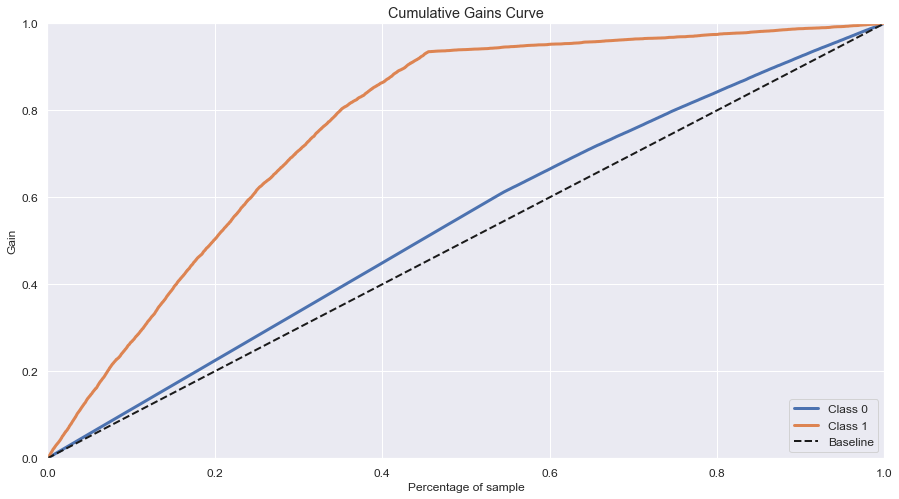

In [104]:
skplt.metrics.plot_cumulative_gain(y_val,yhat_knn);

## 6.2 LOGISTIC REGRESSION

In [214]:
lr_model = lr(max_iter=200)

lr_model.fit(x_train,y_train)

yhat_lr = lr_model.predict_proba(x_validation)


In [216]:
yhat_lr

array([[1.00000000e+000, 9.46711596e-038],
       [1.00000000e+000, 1.36704716e-095],
       [1.00000000e+000, 2.58733879e-072],
       ...,
       [1.00000000e+000, 2.30732928e-101],
       [8.81809453e-001, 1.18190547e-001],
       [1.00000000e+000, 2.99289327e-083]])

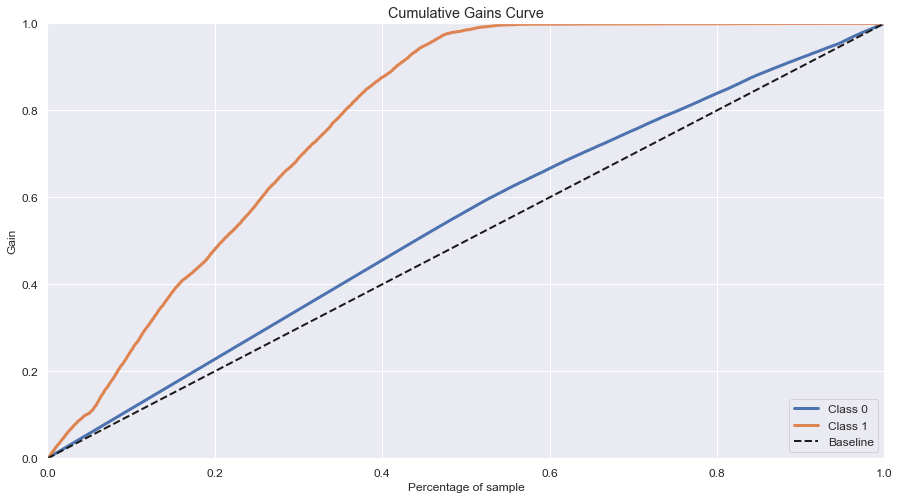

In [106]:
skplt.metrics.plot_cumulative_gain(y_val,yhat_lr);

## 6.3 EXTRA TREES

In [107]:
et =  en.ExtraTreesClassifier(n_estimators=300,n_jobs=-1,random_state=42)
et.fit(x_train,y_train)
yhat_et = et.predict_proba(x_validation)

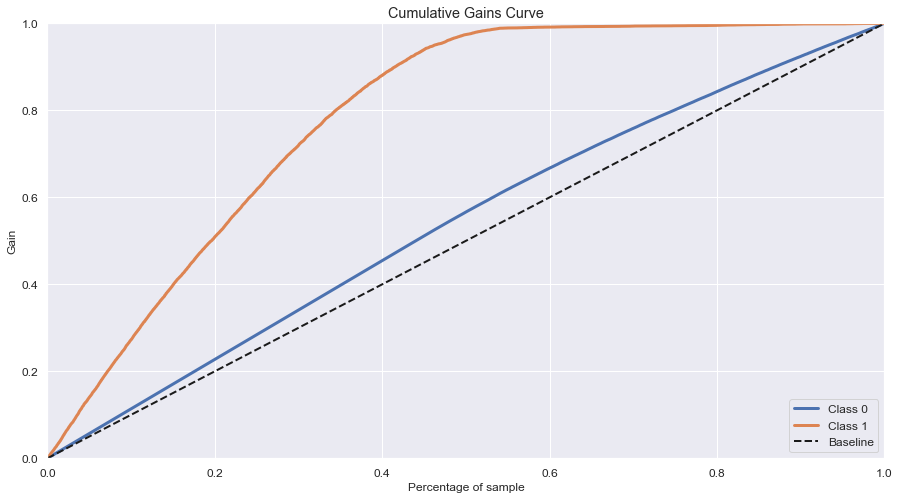

In [108]:
skplt.metrics.plot_cumulative_gain(y_val,yhat_et);

# 7.0 MODEL PERFORMANCE - CROSS VALIDATION

For Logistic Regression and Extra Trees.

## 7.1 LOGISTIC REGRESSION

In [109]:
#cv.runCrossValidation(lr_model, x_train, x_validation,y_train,y_val, n_splits = 5, n_repeats = 2, top_k = 30000, verbose=False)

## 7.2 EXTRA TREES

In [110]:
#cv.runCrossValidation(et, x_train, x_validation,y_train,y_val, n_splits = 5, n_repeats = 2, top_k = 30000, verbose=False)

The model chosen was the Logistic regression because it runs approximately 4x faster than ExtraTrees, while having very close precision and recall numbers in comparison.

# 8.0 HYPERPARAMETER FINE TUNING

In [57]:
lr_model = lr(penalty = 'none',
                              solver = 'sag',
                              class_weight = 'balanced',
                              max_iter = 1000,
                              n_jobs=-1)

#cv.runCrossValidation(lr_model, x_train, x_validation,y_train,y_val, n_splits = 5, n_repeats = 2, top_k = 30000, verbose=False)
lr_model.fit(x_train,y_train)

LogisticRegression(class_weight='balanced', max_iter=1000, n_jobs=-1,
                   penalty='none', solver='sag')

In [58]:
pickle.dump(lr_model, open('/Users/gusta/Documents/repos/health-cross-sell/model/lrmodel.pkl', 'wb'))

# 9.0 DEPLOYMENT

## 9.1 HEALTH INSURANCE CLASS

In [113]:
import pickle
import numpy as np
import pandas as pd

class HealthInsurance:
    def __init__(self):
        self.home_path = '/Users/gusta/Documents/repos/health-cross-sell/'
        self.age_scaler =                  pickle.load(open(self.home_path + 'scalers/age_scaler.pkl')) 
        self.annual_premium_scaler =       pickle.load(open(self.home_path + 'scalers/annual_premium_scaler.pkl'))
        self.gender_scaler =               pickle.load(open(self.home_path + 'scalers/gender_scaler.pkl'))
        self.policy_sales_channel_scaler = pickle.load(open(self.home_path + 'scalers/policy_sales_channel_scaler.pkl'))
        self.region_code_scaler =          pickle.load(open(self.home_path + 'scalers/region_code_scaler.pkl'))
        self.vintage_scaler =              pickle.load(open(self.home_path + 'scalers/vintage_scaler.pkl'))
        
    def data_cleaning(self,data):
        cols_new = ['id','gender','age','driving_license','region_code','previously_insured','vehicle_age','vehicle_damage','annual_premium','policy_sales_channel','vintage','response']
        data.columns = cols_new
        return data
    
    def feature_engineering(self,data):
        dict_vehicle_age = {'> 2 Years':'over_2_years', '1-2 Year':'between_1_2_years', '< 1 Year':'under_1_year'}
        data['vehicle_age'] = data['vehicle_age'].map(dict_vehicle_age)
        
        dict_vehicle_damage = {'Yes': 1, 'No': 0}
        data['vehicle_damage'] = data['vehicle_damage'].map(dict_vehicle_damage)

        return data
    
    def data_preparation(self,data):
        data['annual_premium'] = self.vintage_scaler.transform(data[['annual_premium']].values)
        data['age'] = self.age_scaler.transform(data[['age']].values)
        data['vintage'] = self.vintage_scaler.transform(data[['vintage']].values)
        data.loc[:,'gender'] = data['gender'].map(self.gender_scaler)
        data.loc[:,'region_code'] = data['region_code'].map(self.region_code_scaler)
        data = pd.get_dummies(data,prefix='vehicle_age',columns=['vehicle_age'])
        data.loc[:,'policy_sales_channel'] = data['policy_sales_channel'].map(self.policy_sales_channel_scaler)
        return data
    
    def feature_selection(self,data):
        cols_selected = ['vintage','annual_premium','age','region_code','vehicle_damage','policy_sales_channel','previously_insured']   
        return data[cols_selected]
    
    def get_prediction(self,model,original_data,test_data):
        pred = model.predict_proba(test_data)
        original_data['score'] = pred
        return original_data.to_json(orient='records',date_format='iso')

## 9.2 API HANDLER

In [120]:
import pickle
import pandas as pd
from flask import Flask, request, Response
from healthinsurance import HealthInsurance

path = '/Users/gusta/Documents/repos/health-cross-sell/'
model = pickle.load(open(path + 'model/lrmodel.pkl','rb')) 

app = Flask(__name__)

@app.route('/predict', methods=['POST'])



def health_insurance_predict():
    test_json = request.get_json()
    if test_json:
        if isinstance(test_json,dict):
            test_raw = pd.Dataframe(test_json,index=[0])
        else:
            test_raw = pd.Dataframe(test_json,columns=test_json[0].keys())
    
        pipeline = HealthInsurance()
        df1 = pipeline.data_cleaning(test_raw)
        df2 = pipeline.feature_engineering(df1)
        df3 = pipeline.data_preparation(df2)
        df4 = pipeline.feature_selection(df3)
        df_response = pipeline.get_prediction(model, test_raw, df4)
        return df_response
    else:
        return Response('{}',status=200,mimetype='application/json')

if __name__ == '__main__':
    app.run('0.0.0.0',debug=True)

 * Serving Flask app '__main__'
 * Debug mode: on


 * Running on all addresses (0.0.0.0)
 * Running on http://127.0.0.1:5000
 * Running on http://192.168.0.14:5000
Press CTRL+C to quit
 * Restarting with stat


SystemExit: 1

In [45]:
import requests

In [63]:
data={'id':381158, 'region_code':30.0, 'age':54, 'gender':'Male', 'vehicle_age':'1-2 Year', 'policy_sales_channel':156.0, 'annual_premium':23364.0, 'previously_insured':0, 'vintage':217, 'driving_license':1, 'vehicle_damage':'Yes'}

In [64]:
data

{'id': 381158,
 'region_code': 30.0,
 'age': 54,
 'gender': 'Male',
 'vehicle_age': '1-2 Year',
 'policy_sales_channel': 156.0,
 'annual_premium': 23364.0,
 'previously_insured': 0,
 'vintage': 217,
 'driving_license': 1,
 'vehicle_damage': 'Yes'}

In [47]:
data = json.dumps(df_test.to_dict(orient='records'))

In [48]:
data

'[{"id": 21436, "gender": "Female", "age": 29, "region_code": 14.0, "policy_sales_channel": 152.0, "driving_license": 1, "vehicle_age": "< 1 Year", "vehicle_damage": "No", "previously_insured": 0, "annual_premium": 26291.0, "vintage": 223}, {"id": 117284, "gender": "Female", "age": 29, "region_code": 28.0, "policy_sales_channel": 152.0, "driving_license": 1, "vehicle_age": "< 1 Year", "vehicle_damage": "No", "previously_insured": 1, "annual_premium": 43241.0, "vintage": 180}, {"id": 285337, "gender": "Male", "age": 47, "region_code": 28.0, "policy_sales_channel": 25.0, "driving_license": 1, "vehicle_age": "1-2 Year", "vehicle_damage": "Yes", "previously_insured": 0, "annual_premium": 40363.0, "vintage": 114}, {"id": 316964, "gender": "Male", "age": 59, "region_code": 28.0, "policy_sales_channel": 26.0, "driving_license": 1, "vehicle_age": "1-2 Year", "vehicle_damage": "No", "previously_insured": 1, "annual_premium": 40625.0, "vintage": 238}, {"id": 371240, "gender": "Male", "age": 56, 

In [49]:
url = 'https://health-ccross-sell.herokuapp.com/predict'
header = {'Content-type':'application/json'}

r = requests.post(url,data=data,headers=header)
print(r.status_code)

200


In [50]:
d1 = pd.DataFrame(r.json(),columns=r.json()[0].keys())
d1.sort_values('score',ascending=False)

,id,gender,age,region_code,policy_sales_channel,driving_license,vehicle_age,vehicle_damage,previously_insured,annual_premium,vintage,score
2,285337,0.138278,0.415385,0.187021,25.0,1,between_1_2_years,1,0,139.629758,0.359862,0.664944
6,318563,0.138278,0.461538,0.187021,13.0,1,between_1_2_years,1,0,141.830450,0.332180,0.661458
4,371240,0.138278,0.553846,0.095908,26.0,1,between_1_2_years,1,0,9.065744,0.294118,0.640919
8,280137,0.104072,0.292308,0.102868,157.0,1,between_1_2_years,1,0,80.301038,0.823529,0.630015
9,233713,0.138278,0.507692,0.187021,158.0,1,between_1_2_years,1,0,178.373702,0.723183,0.623946
7,221574,0.104072,0.415385,0.063695,152.0,1,between_1_2_years,1,0,127.408304,0.332180,0.446185
0,21436,0.104072,0.138462,0.090836,152.0,1,under_1_year,0,0,90.937716,0.737024,0.118581
3,316964,0.138278,0.600000,0.187021,26.0,1,between_1_2_years,0,1,140.536332,0.788927,0.003351
1,117284,0.104072,0.138462,0.187021,152.0,1,under_1_year,0,1,149.588235,0.588235,0.002971
5,244556,0.104072,0.046154,0.096312,152.0,1,under_1_year,0,1,148.079585,0.283737,0.001953
